In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Sat Jan 20 22:49:36 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   43C    P0    46W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.sep_lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = True
hp.z_activation = F.tanh
hp.activation = F.sigmoid

# ''' Find Optimum Log-Sigma'''
# from util.loglikelihood import get_optimum_log_sigma

# p_samples1 = (torch.rand(hp.M, 1)*2-1).cuda()
# p_samples2 = (torch.rand(hp.M, 1)*2-1).cuda()
# log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2, -10, 10) for _ in range(100)])
hp.init_log_sigma = -8
print(hp.init_log_sigma)

-8


In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 3.814697265625e-06
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.20-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 43592
-rw-rw-r-- 1 scpark scpark   103061  1월 20 22:49 events.out.tfevents.1705758245.GPUSVR11
-rw-rw-r-- 1 scpark scpark 44176689  1월 20 22:44 save_0
-rw-rw-r-- 1 scpark scpark     4399  1월 20 22:42 events.out.tfevents.1705758051.GPUSVR11
-rw-rw-r-- 1 scpark scpark   185533  1월 20 22:40 events.out.tfevents.1705757430.GPUSVR11
-rw-rw-r-- 1 scpark scpark   118724  1월 20 21:50 events.out.tfevents.1705754678.GPUSVR11
-rw-rw-r-- 1 scpark scpark    12452  1월 20 21:44 events.out.tfevents.1705754601.GPUSVR11
-rw-rw-r-- 1 scpark scpark    15332  1월 20 21:43 events.out.tfevents.1705754523.GPUSVR11
-rw-rw-r-- 1 scpark scpark     1540  1월 20 21:41 events.out.tfevents.1705754456.GPUSVR11


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=hp.N, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.0003], device='cuda:0')


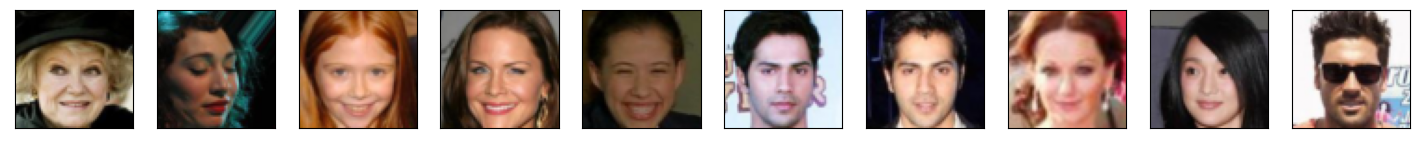

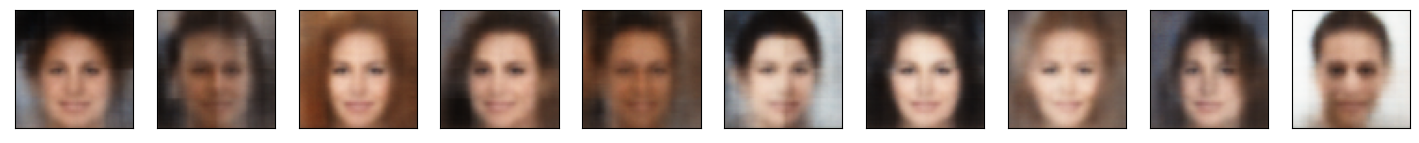

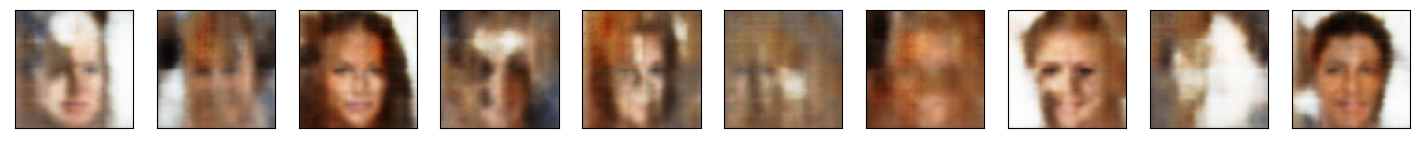

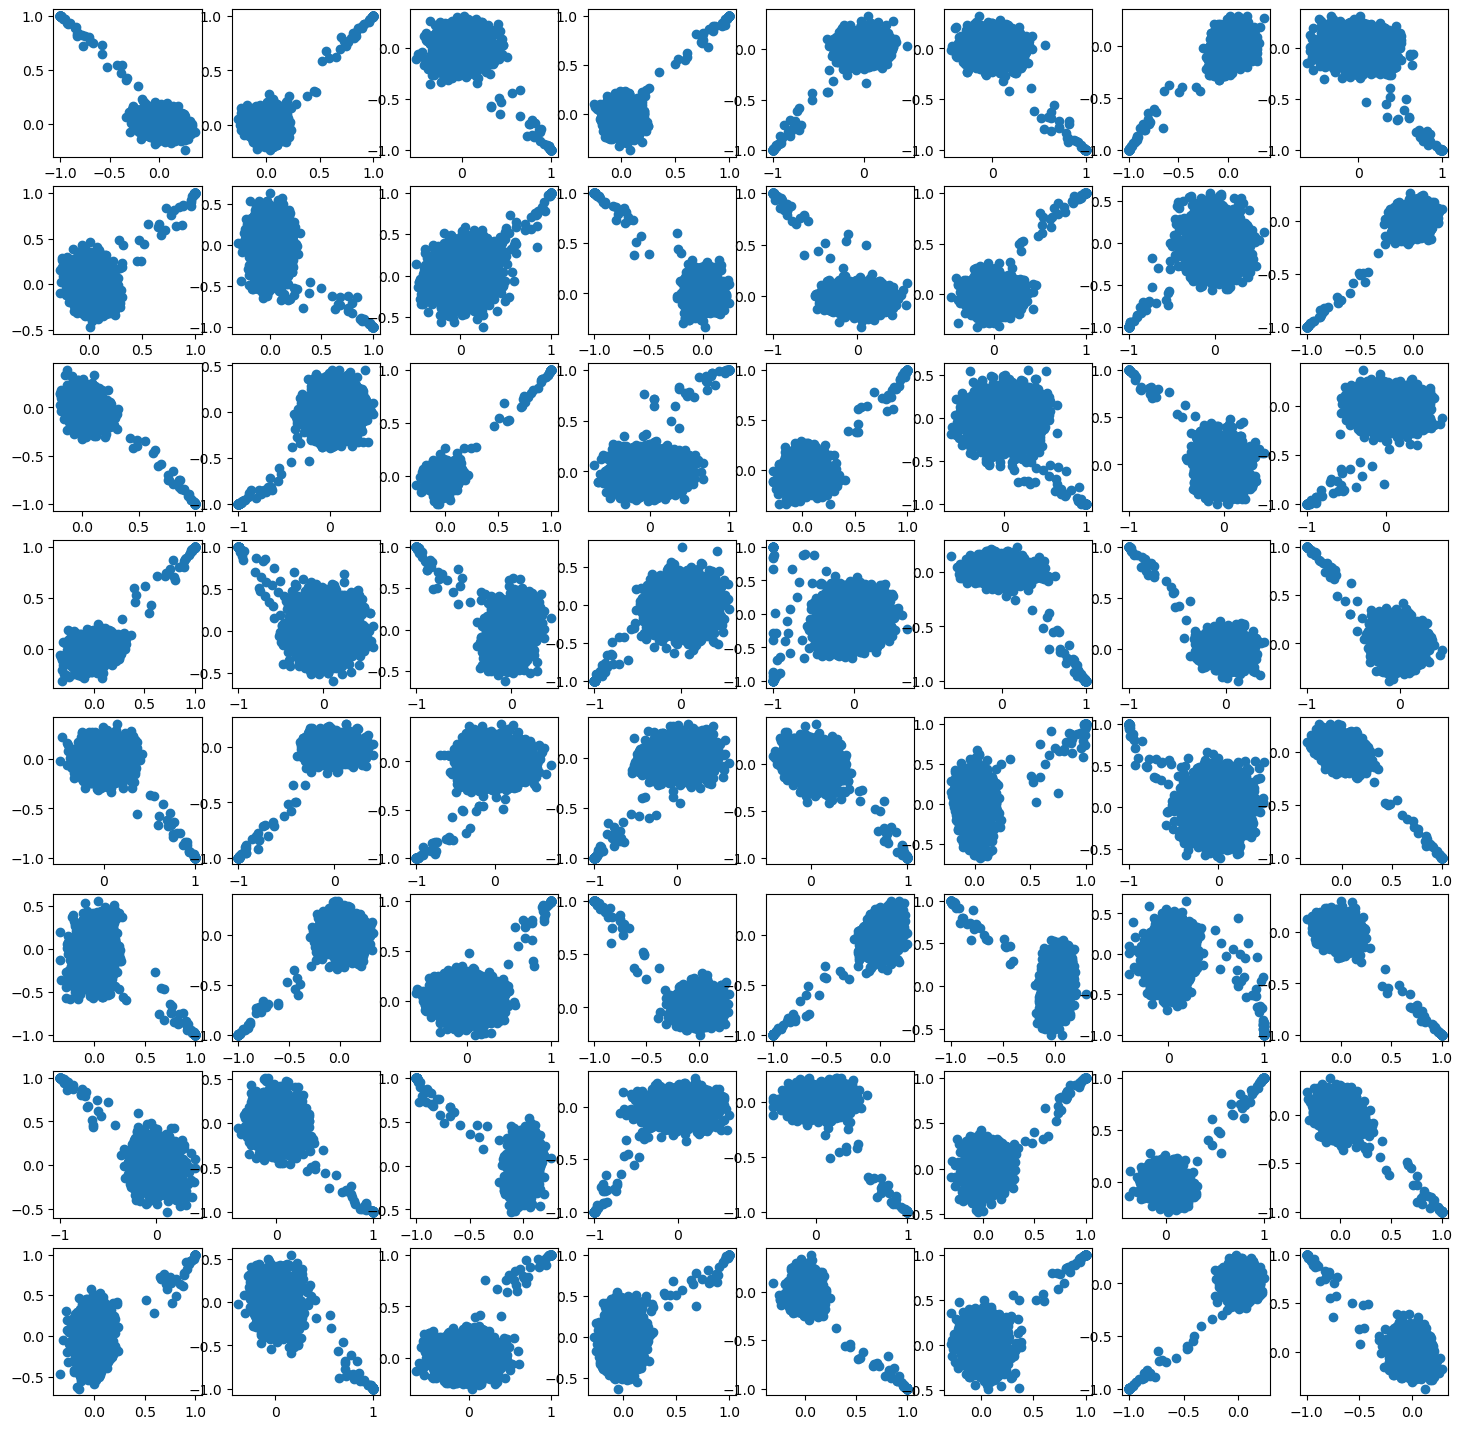

2001
lse_loss 179237168.0
recon_loss 0.029377978295087814
2002
lse_loss 178959664.0
recon_loss 0.030508331954479218
2003
lse_loss 177999216.0
recon_loss 0.030843591317534447
2004
lse_loss 179212896.0
recon_loss 0.02849050611257553
2005
lse_loss 178984288.0
recon_loss 0.02907412312924862
2006
lse_loss 179557232.0
recon_loss 0.029704740270972252
2007
lse_loss 178548432.0
recon_loss 0.028584685176610947
2008
lse_loss 179882896.0
recon_loss 0.029643183574080467
2009
lse_loss 179061856.0
recon_loss 0.029403602704405785
2010
lse_loss 178988512.0
recon_loss 0.03256478160619736
2011
lse_loss 178790704.0
recon_loss 0.030001094564795494
2012
lse_loss 179032320.0
recon_loss 0.030020203441381454
2013
lse_loss 178812384.0
recon_loss 0.02992597594857216
2014
lse_loss 178651072.0
recon_loss 0.029946818947792053
2015
lse_loss 178586896.0
recon_loss 0.02972790226340294
2016
lse_loss 178997728.0
recon_loss 0.029870804399251938
2017
lse_loss 178664576.0
recon_loss 0.03020777367055416
2018
lse_loss 179279

2144
lse_loss 179315872.0
recon_loss 0.031798288226127625
2145
lse_loss 178765744.0
recon_loss 0.03207400068640709
2146
lse_loss 178821312.0
recon_loss 0.03219345957040787
2147
lse_loss 178730624.0
recon_loss 0.03169006109237671
2148
lse_loss 178202624.0
recon_loss 0.0333956778049469
2149
lse_loss 178597488.0
recon_loss 0.031761959195137024
2150
lse_loss 178558144.0
recon_loss 0.031178772449493408
2151
lse_loss 179423456.0
recon_loss 0.031764548271894455
2152
lse_loss 179826624.0
recon_loss 0.032577868551015854
2153
lse_loss 178337920.0
recon_loss 0.033789731562137604
2154
lse_loss 178236768.0
recon_loss 0.032941170036792755
2155
lse_loss 177860336.0
recon_loss 0.03091508150100708
2156
lse_loss 178829408.0
recon_loss 0.032075297087430954
2157
lse_loss 179391120.0
recon_loss 0.03152365982532501
2158
lse_loss 178862064.0
recon_loss 0.03339666128158569
2159
lse_loss 178829696.0
recon_loss 0.030803261324763298
2160
lse_loss 178522816.0
recon_loss 0.030821219086647034
2161
lse_loss 17786096

2287
lse_loss 178588192.0
recon_loss 0.02824656292796135
2288
lse_loss 178417696.0
recon_loss 0.028471630066633224
2289
lse_loss 179245024.0
recon_loss 0.02800699695944786
2290
lse_loss 178716032.0
recon_loss 0.027891581878066063
2291
lse_loss 178438896.0
recon_loss 0.026002852246165276
2292
lse_loss 178025344.0
recon_loss 0.027539988979697227
2293
lse_loss 179609248.0
recon_loss 0.02752685546875
2294
lse_loss 178823168.0
recon_loss 0.028949862346053123
2295
lse_loss 178921744.0
recon_loss 0.02900633215904236
2296
lse_loss 179017936.0
recon_loss 0.029505042359232903
2297
lse_loss 178614432.0
recon_loss 0.028876151889562607
2298
lse_loss 178383024.0
recon_loss 0.031607627868652344
2299
lse_loss 178620848.0
recon_loss 0.029036736115813255
2300
lse_loss 178633120.0
recon_loss 0.0285329706966877
2301
lse_loss 178392736.0
recon_loss 0.03083360195159912
2302
lse_loss 178703712.0
recon_loss 0.029186345636844635
2303
lse_loss 179025056.0
recon_loss 0.02928057312965393
2304
lse_loss 178547136.0

2430
lse_loss 177913888.0
recon_loss 0.02810961753129959
2431
lse_loss 178187904.0
recon_loss 0.02747420221567154
2432
lse_loss 178363888.0
recon_loss 0.02746446058154106
2433
lse_loss 178246240.0
recon_loss 0.027697836980223656
2434
lse_loss 178284384.0
recon_loss 0.02603287249803543
2435
lse_loss 177648208.0
recon_loss 0.02665918692946434
2436
lse_loss 178946576.0
recon_loss 0.027310237288475037
2437
lse_loss 178470352.0
recon_loss 0.02664489671587944
2438
lse_loss 178956448.0
recon_loss 0.02675226330757141
2439
lse_loss 177761024.0
recon_loss 0.026647618040442467
2440
lse_loss 178987648.0
recon_loss 0.026164768263697624
2441
lse_loss 179414096.0
recon_loss 0.027521714568138123
2442
lse_loss 179038016.0
recon_loss 0.028111090883612633
2443
lse_loss 179312672.0
recon_loss 0.025701619684696198
2444
lse_loss 178526592.0
recon_loss 0.028075380250811577
2445
lse_loss 177870496.0
recon_loss 0.026196565479040146
2446
lse_loss 179432704.0
recon_loss 0.02749462053179741
2447
lse_loss 17843315

2573
lse_loss 178374592.0
recon_loss 0.02680182456970215
2574
lse_loss 178053824.0
recon_loss 0.027053793892264366
2575
lse_loss 178945376.0
recon_loss 0.026810867711901665
2576
lse_loss 178238528.0
recon_loss 0.028485244140028954
2577
lse_loss 179478400.0
recon_loss 0.026865676045417786
2578
lse_loss 179316032.0
recon_loss 0.02901288866996765
2579
lse_loss 178647184.0
recon_loss 0.026558710262179375
2580
lse_loss 178386304.0
recon_loss 0.027167145162820816
2581
lse_loss 179099264.0
recon_loss 0.02717813476920128
2582
lse_loss 179471072.0
recon_loss 0.02611430548131466
2583
lse_loss 178956272.0
recon_loss 0.026648519560694695
2584
lse_loss 179014720.0
recon_loss 0.025622587651014328
2585
lse_loss 178199712.0
recon_loss 0.02715235762298107
2586
lse_loss 178722896.0
recon_loss 0.027572467923164368
2587
lse_loss 178900416.0
recon_loss 0.026493659242987633
2588
lse_loss 177916416.0
recon_loss 0.02765275165438652
2589
lse_loss 178372592.0
recon_loss 0.02659509889781475
2590
lse_loss 1783523

2716
lse_loss 178406112.0
recon_loss 0.029363004490733147
2717
lse_loss 178506912.0
recon_loss 0.03047076240181923
2718
lse_loss 178272304.0
recon_loss 0.028261110186576843
2719
lse_loss 178598576.0
recon_loss 0.02963828854262829
2720
lse_loss 178655712.0
recon_loss 0.028899168595671654
2721
lse_loss 178342304.0
recon_loss 0.027991613373160362
2722
lse_loss 178817408.0
recon_loss 0.028772039338946342
2723
lse_loss 178272432.0
recon_loss 0.02870168350636959
2724
lse_loss 178773760.0
recon_loss 0.029333800077438354
2725
lse_loss 178703344.0
recon_loss 0.027422552928328514
2726
lse_loss 179513664.0
recon_loss 0.028100743889808655
2727
lse_loss 177836880.0
recon_loss 0.028942376375198364
2728
lse_loss 178279616.0
recon_loss 0.028293952345848083
2729
lse_loss 178512832.0
recon_loss 0.02815527282655239
2730
lse_loss 178960976.0
recon_loss 0.028854310512542725
2731
lse_loss 178711792.0
recon_loss 0.027912430465221405
2732
lse_loss 179661728.0
recon_loss 0.028283897787332535
2733
lse_loss 1785

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            print(torch.exp(model_list[0].latent.log_sigma))
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            z = data['z'].data.cpu().numpy()
            plt.figure(figsize=[18, 18])
            for i in range(64):
                plt.subplot(8, 8, i+1)
                plt.scatter(z[:, i*2], z[:, i*2+1])
            plt.show()    
                
            from util.mmd_penalty import mmd_penalty
            opts = {'pz_scale': 1,
                    'mmd_kernel': 'RBF', # 'IMQ', 'RBF'
                    'pz': 'normal', # 'normal', 'sphere', 'uniform' 
                    'zdim': hp.z_dim
                   } 
            e = (torch.rand_like(data['z'])*2-1)
            mmd = mmd_penalty(data['z'], e, opts).item()
            writer.add_scalar('MMD', mmd, step)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')